In [170]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import math
from scipy.constants import N_A

In [171]:
Target_cell_number = 2e4
well_size = 50e-6
sigma = well_size*N_A/Target_cell_number
tumour_cell_radius = 7.25e-6
t_end = 60*60*1
t = np.geomspace(1e-10, t_end, 500)
t_span = [1e-10, t_end]
z0 = [0, 0]
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
A0s = np.geomspace(1e-12, 1e-5, 350)

In [172]:
def model_S_monospecific(t, z, Ainit, rtot, kon, k2, koff):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/Atot) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

def monovalent_binding(t, z, Ainit, rtot, kon, koff):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z
     Ag = rtot - z

     dA1 = k*Ag*A0/Atot - koff*z

     return dA1

def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    Atot = sigma*Ainit
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

def mono_valent_steady_state(Ainit, k1, koff, rtot):
    k1 = k1/sigma
    Atot = sigma*Ainit
    a = 1
    b = -((koff/k1) + rtot + Atot)
    c = rtot*Atot

    st = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

    return st

def EC50_finder(rtot, array, A0s):
    half_max = 0.5*rtot
    half_max_array = half_max*np.ones_like(array)
    indicies = np.argwhere(np.diff(np.sign(half_max_array-array)))
    return A0s[indicies[0]]

def EC90_finder(rtot, array, A0s):
    half_max = 0.9*rtot
    half_max_array = half_max*np.ones_like(array)
    indicies = np.argwhere(np.diff(np.sign(half_max_array-array)))
    return A0s[indicies[0]]

[]

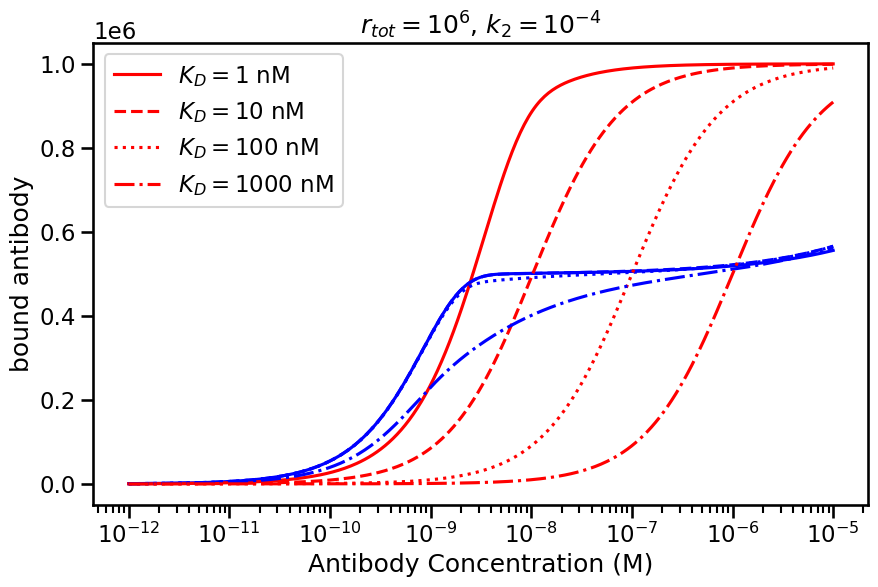

In [173]:
kon = 1e5
koff = 1e-4
D = 1e-15
rtot = 1e6
k2 = 4*D/tumour_cell_surface_area
k2 = 1e-4
koffs = [1e-4, 1e-3, 1e-2, 1e-1]

biv_sol = [np.ones_like(A0s) for i in range(len(koffs))] 
mono_sol = [np.ones_like(A0s) for i in range(len(koffs))]

for j, koff in enumerate(koffs):
    for i, Ainit in enumerate(A0s):
    
        z = solve_ivp(model_S_monospecific, t_span, z0, method='Radau', t_eval=t, args=(Ainit, rtot, kon, k2, koffs[j]))
        A1 = z.y[0]
        A2 = z.y[1]
        sol_b = biv_sol[j]
        sol_b[i] = A1[-1] + A2[-1]
        biv_sol[j] = sol_b

    
        z = solve_ivp(monovalent_binding, t_span, [0], method='Radau', t_eval=t, args=(Ainit, rtot, kon, koffs[j]))
        A1 = z.y[0]
        sol = mono_sol[j]
        sol[i] = A1[-1]
        mono_sol[j] = sol

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(10, 6))
linestyles=['solid', 'dashed', 'dotted', 'dashdot']
labels = [r'$K_D=1$ nM', r'$K_D=10$ nM', r'$K_D=100$ nM', r'$K_D=1000$ nM']
for i in range(len(mono_sol)):
    plt.plot(A0s, biv_sol[i], c='blue', linestyle=linestyles[i])
    plt.plot(A0s, mono_sol[i], c='red', label=labels[i], linestyle=linestyles[i])
plt.xscale('log')
plt.legend(loc='best')
plt.ylabel('bound antibody')
plt.title(r'$r_{tot}=10^6$, $k_2=10^{-4}$')
plt.xlabel('Antibody Concentration (M)')
plt.plot()

In [174]:
rtots = np.geomspace(1e3, 1e6, 50)
biv_ec50 = np.ones_like(rtots)
mono_ec50s = [np.ones_like(rtots) for i in range(len(koffs))] 
for i, rtot in enumerate(rtots):
    biv_sol = np.ones_like(A0s)
    mono_sol = [np.ones_like(A0s) for f in range(len(koffs))] 
    print(i)
    for j, Ainit in enumerate(A0s):
    
        z = solve_ivp(model_S_monospecific, t_span, z0, method='Radau', t_eval=t, args=(Ainit, rtot, kon, k2, koff))
        A1 = z.y[0]
        A2 = z.y[1]
        biv_sol[j] = A1[-1] + A2[-1]

        for k, koff in enumerate(koffs):
            z = solve_ivp(monovalent_binding, t_span, [0], method='Radau', t_eval=t, args=(Ainit, rtot, kon, koff))
            A1 = z.y[0]
            sol = mono_sol[k]
            sol[j] = A1[-1]
            mono_sol[k] = sol
    for l in range(len(mono_ec50s)):
        holder = mono_ec50s[l]
        holder[i] = EC90_finder(rtot, mono_sol[l], A0s)
        mono_ec50s[l] = holder
    biv_ec50[i] = EC90_finder(rtot, biv_sol, A0s)

    

0


KeyboardInterrupt: 

[]

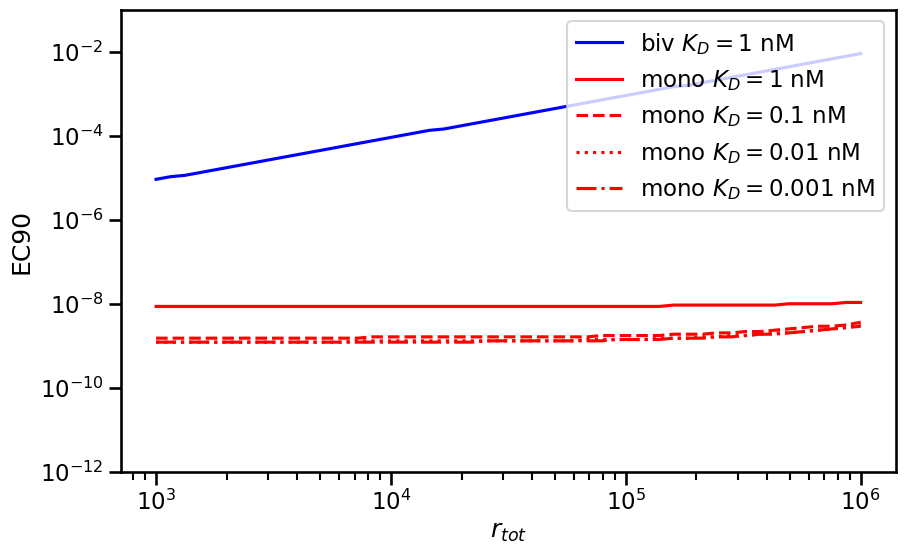

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
linestyles=['solid', 'dashed', 'dotted', 'dashdot']
labels = [r'mono $K_D=1$ nM', r'mono $K_D=0.1$ nM', r'mono $K_D=0.01$ nM', r'mono $K_D=0.001$ nM']
plt.plot(rtots, biv_ec50, c='blue', label=r'biv $K_D=1$ nM')
for i in range(len(mono_ec50s)):
    plt.plot(rtots, mono_ec50s[i], c='red', label=labels[i], linestyle=linestyles[i])
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.ylabel('EC90')
plt.ylim(1e-12, 1e-1)
plt.xlabel(r'$r_{tot}$')
plt.plot()